In [1]:
from pathlib import Path
import numpy as np

from my_types import Vec3, Quat, ScalarBatch
from my_types import as_vec3, as_scalar_batch
from io_csv import load_gyro_base, load_ref, load_acc, load_mag, load_grav_ref, load_acc_lin_ref
from pipelines import integrate_gyro_acc_mag
from evaluation import calc_angle_err, print_err_status, save_err_csv,plot_err_from_csv, save_estimated_vec3_csv
from evaluation import evaluate_estimated_vec3_autosign
import lib_quat as libq

EPS: float = 1e-9

In [2]:
root: Path = Path.cwd().parent
run_dir: Path = root / "data" / "21:08_oct_07_2025_5min"

ori_path: Path = run_dir / "Orientation.csv"
gyro_path: Path = run_dir / "Gyroscope.csv"
grav_path: Path = run_dir / "Gravity.csv"
acc_path: Path = run_dir / "AccelerometerUncalibrated.csv"
acc_lin_path: Path = run_dir / "Accelerometer.csv"
mag_path: Path = run_dir / "Magnetometer.csv"

for p in [ori_path, gyro_path, grav_path, acc_path, acc_lin_path, mag_path]:
        if not p.exists():
                raise FileNotFoundError(f"File not found: {p}")

In [3]:
t_src_gyro, w_src_gyro, dt, t_new, w_avg_gyro = load_gyro_base(gyro_path)

q_ref_interp = load_ref(ori_path, t_new)
q_ref_interp /= np.linalg.norm(q_ref_interp, axis=1, keepdims=True)

a_src_interp = load_acc(acc_path, t_new)

m_src_interp = load_mag(mag_path, t_new)

In [4]:
q0: Quat = q_ref_interp[0].copy()

K_acc: float = 0.01
g0: float = 9.80665
acc_gate_sigma: float = 0.2
g_world_unit: Vec3 = as_vec3(np.array([0, 0, -1]))

K_mag: float = 0.011

m0: float = np.median(np.linalg.norm(m_src_interp, axis=1))
mag_gate_sigma: float = 0.257 * m0
if mag_gate_sigma < EPS:
        mag_gate_sigma = 1

""""""
# build mag_ref_world_h from reference orientation over stable window
mask: ScalarBatch = as_scalar_batch((np.abs(np.linalg.norm(a_src_interp, axis=1) - g0 < EPS))
                   & (np.linalg.norm(m_src_interp, axis=1) > EPS))
idx: ScalarBatch = as_scalar_batch(np.where(mask)[0][:3000]) # first 3
accum: Vec3 = as_vec3(np.zeros(3))
cnt: int = 0
for i in idx:
        m_unit: Vec3 = m_src_interp[i] / max(np.linalg.norm(m_src_interp[i]), EPS)
        m_world: Vec3 = libq.rotate_body_to_world(q_ref_interp[i], m_unit)
        m_world_h: Vec3 = m_world - np.dot(m_world, g_world_unit) * g_world_unit
        n: float = np.linalg.norm(m_world_h)
        if n > EPS:
                accum += m_world_h / n
                cnt += 1
mag_ref_world_h: Vec3 = accum / max(np.linalg.norm(accum), EPS)
""""""

q_gyro_acc_mag, g_body_est, a_lin_est = integrate_gyro_acc_mag(q0, w_avg_gyro, dt,
                                                       K_acc, g0, g_world_unit, acc_gate_sigma, a_src_interp,
                                                       K_mag, m0, mag_ref_world_h, mag_gate_sigma, m_src_interp)

angle_err_gyro_acc_mag: ScalarBatch = calc_angle_err(q_gyro_acc_mag, q_ref_interp)
print_err_status("Gyro + Acc + Mag", angle_err_gyro_acc_mag)

weight_acc  pcts: [0.00000000e+00 2.07622933e-40 3.12946471e-17 1.13631551e-04
 2.54794588e-01 7.17315871e-01 9.87649188e-01]
weight_mag  pcts: [0.04233255 0.95033942 0.98790434 0.99808048 0.99971898 0.99993014
 0.99999731]
dev  pcts: [8.84298486e-05 8.52410673e-01 1.74363041e+00 2.70366937e+00
 3.80954047e+00 4.82779302e+00 8.45995460e+00]

Gyro + Acc + Mag angle error in rad — min/max/mean
0.0017564423183733173 0.5296602262390369 0.04217184366823614

Gyro + Acc + Mag angle error in deg — min/max/mean
0.10063673180096473 30.347295539441156 2.4162686564754345


In [5]:
out_dir: Path = root / "output"
out_dir.mkdir(parents=True, exist_ok=True)
out_path: Path = out_dir / "03_angle_err_gyro_acc_mag.csv"
save_err_csv(out_path, t_new, angle_err_gyro_acc_mag)

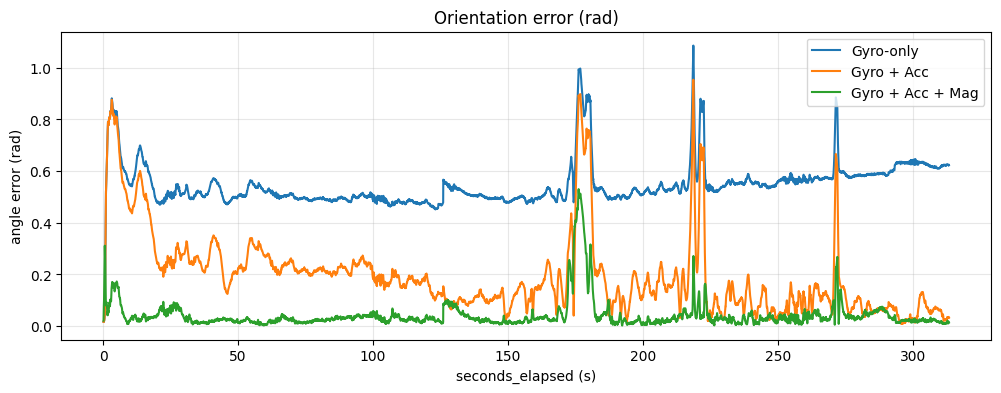

In [6]:
out_gyro_path = out_dir / "01_angle_err_gyro.csv"
out_acc_path = out_dir / "02_angle_err_gyro_acc.csv"
out_mag_path = out_dir / "03_angle_err_gyro_acc_mag.csv"

plot_err_from_csv([
        ("Gyro-only", out_gyro_path),
        ("Gyro + Acc", out_acc_path),
        ("Gyro + Acc + Mag", out_mag_path)
])

In [7]:
est_dir: Path = root / "estimate"
est_dir.mkdir(parents=True, exist_ok=True)

print("Gravity:")
g_ref_interp = load_grav_ref(grav_path, t_new)
g_est_sign_fixed, g_rmse_norm = evaluate_estimated_vec3_autosign(g_body_est, g_ref_interp)
print("")

print("Linear Acc:")
a_lin_ref_interp = load_acc_lin_ref(acc_lin_path, t_new)
a_lin_est_sign_fixed, a_lin_rmse_norm = evaluate_estimated_vec3_autosign(a_lin_est, a_lin_ref_interp)
print("")

save_estimated_vec3_csv(est_dir / "03_gravity_estimated.csv", t_new, g_est_sign_fixed)
save_estimated_vec3_csv(est_dir / "03_linear_acc_estimated.csv", t_new, a_lin_est_sign_fixed)

print("consistency ratio (a_lin / g):", a_lin_rmse_norm / max(g_rmse_norm, EPS))

Gravity:
RMSE norm: 0.22457566912238214

Linear Acc:
RMSE norm: 0.7666022364937669

consistency ratio (a_lin / g): 3.4135587327405816


In [8]:
import numpy as np

def unit(v):
    n = np.linalg.norm(v, axis=1, keepdims=True)
    return v / np.maximum(n, 1e-12)

def gravity_direction_angle_err(g_est: np.ndarray, g_ref: np.ndarray):
    ge = unit(g_est)
    gr = unit(g_ref)
    c = np.sum(ge * gr, axis=1)
    c = np.clip(c, -1.0, 1.0)
    ang = np.arccos(c)  # rad
    print("gravity dir angle err (rad): min/max/mean",
          float(ang.min()), float(ang.max()), float(ang.mean()))
    print("gravity dir angle err (deg): min/max/mean",
          float(np.rad2deg(ang.min())), float(np.rad2deg(ang.max())), float(np.rad2deg(ang.mean())))
    return ang

def accel_gravity_alignment(a_src: np.ndarray, g_est: np.ndarray, g0: float, thr: float = 0.3):
    a_norm = np.linalg.norm(a_src, axis=1)
    mask = np.abs(a_norm - g0) < thr

    au = unit(a_src)
    gu = unit(g_est)
    dot = np.sum(au * gu, axis=1)  # 부호는 플랫폼 정의에 따라 +/-1이 목표

    d = dot[mask]
    print(f"stationary mask count: {int(mask.sum())}/{len(mask)}")
    print("dot(a_unit, g_unit) on stationary: mean/min/max",
          float(np.mean(d)), float(np.min(d)), float(np.max(d)))
    return dot, mask

gravity_direction_angle_err(g_est_sign_fixed, g_ref_interp)
print("=============")
accel_gravity_alignment(a_src_interp, g_est_sign_fixed, g0)

gravity dir angle err (rad): min/max/mean 0.00015070486507950715 0.08603278466966592 0.019429862720458126
gravity dir angle err (deg): min/max/mean 0.008634752721144261 4.929315461329668 1.1132491304008267
stationary mask count: 2778/30738
dot(a_unit, g_unit) on stationary: mean/min/max 0.9833865042881748 0.20627184545944424 0.9999980609420976


(array([0.75621525, 0.75374777, 0.75148522, ..., 0.99335016, 0.99420737,
        0.99578548]),
 array([ True,  True,  True, ..., False, False,  True]))